In [120]:
import os
import pickle
import numpy as np
import time
from cv2 import imread
from PIL import Image
import tensorflow as tf
from cv2 import resize
import matplotlib.pyplot as plt

from cv2 import IMREAD_GRAYSCALE
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

In [21]:
def load_imgs(path, n=0, resize_shape=(128,128)):
    X = []
    y = []
    name_dict = {}
    curr_y = n
    for name in os.listdir(path):
        print("Loading Image: " + name)
        name_dict[name] = curr_y
        label_images = []
        name_path = os.path.join(path, name)
        for img in os.listdir(name_path):
            image_path = os.path.join(name_path, img)
            image = imread(image_path, IMREAD_GRAYSCALE)
            resize_image = resize(image, dsize=resize_shape)
            label_images.append(resize_image)
            y.append(curr_y)
        try:
            X.append(np.stack(label_images))
        except ValueError as e:
            print(e)
            print("error - label_images: ", label_images)
        curr_y += 1

    y = np.vstack(y)
    X = np.stack(X)
    return X, y, name_dict

In [169]:
train_path = './Face_data/train'
test_path = './Face_data/test'
save_path = './Face_sub/data/'

In [22]:
X, y, name = load_imgs(train_path)  

Loading Image: choi
Loading Image: kim
Loading Image: lim
Loading Image: si


In [23]:
print(X.shape)
print(y.shape)
print(name)

(4, 6, 128, 128)
(24, 1)
{'choi': 0, 'kim': 1, 'lim': 2, 'si': 3}


In [24]:
# Save Train Data with pickle
with open(os.path.join(save_path, "train.pickle"), "wb") as f:
    pickle.dump((X,name), f)

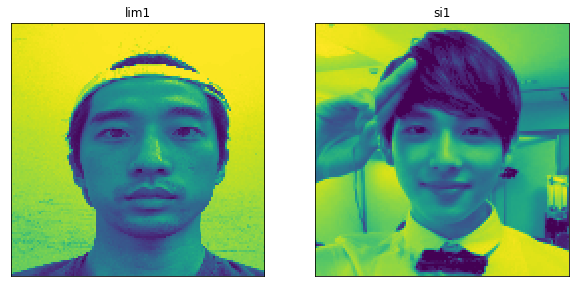

In [499]:
plt.figure(figsize=(10,15))
plt.subplot(1,2,1)
plt.imshow( Xtrain[2,0])
plt.xticks([])
plt.yticks([])
plt.title('lim1')
plt.grid(False)
plt.subplot(1,2,2)
plt.imshow( Xtrain[3,0])
plt.xticks([])
plt.yticks([])
plt.title('si1')
plt.grid(False)
plt.show()

In [32]:
# Load Train Data
with open(os.path.join(save_path, "train.pickle"), "rb") as f:
    Xtrain, name = pickle.load(f)

In [33]:
Xtrain.shape

(4, 6, 128, 128)

In [34]:
name

{'choi': 0, 'kim': 1, 'lim': 2, 'si': 3}

In [27]:
def W_init(shape, name=None):
    """Initialize weights as in paper."""
    values = np.random.normal(loc=0, scale=1e-2, size=shape)
    return K.variable(values, name=name)

def W_init_fc(shape, name=None):
    """Initialize weights in fully connected layer as in paper."""
    values = np.random.normal(loc=0, scale=2e-1, size=shape)
    return K.variable(values, name=name)

def b_init(shape, name=None):
    """Initialize biases as in paper."""
    values = np.random.normal(loc=0.5, scale=1e-2, size=shape)
    return K.variable(values, name=name)

In [36]:
def get_siamese_model(input_shape):
    """ Model Architecture based on paper """

    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    # Convlutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(10, 10), activation='relu', input_shape = input_shape, kernel_initializer=W_init, kernel_regularizer=l2(2e-4))) # why not encluded bias_initializer
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(2048, activation='sigmoid', kernel_initializer=W_init_fc, bias_initializer=b_init, kernel_regularizer=l2(1e-3)))

    # Generate the encoded vectors
    encoded_l = model(left_input)
    encoded_r = model(right_input)

    # Add a custmized layer to compute L1 distance( abs(left - right) )
    L1_layer = Lambda(lambda x: K.abs(x[0] - x[1]), output_shape=lambda x: x[0])
    L1_distance_layer = L1_layer([encoded_l, encoded_r])

    # generate the similarity score
    prediction = Dense(1, activation='sigmoid', bias_initializer=b_init)(L1_distance_layer)

    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)

    return siamese_net

In [507]:
input_shape = (128, 128, 1)
model = get_siamese_model(input_shape)

optimizer = Adam(lr=6e-5)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc']) # 정확도 넣으면 많이 느려짐.

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 2048)         34751296    input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 2048)         0           sequential_5[1][0]               
          

In [508]:
Xtrain[::2, ::2].shape

(2, 3, 128, 128)

In [509]:
y.shape

(24, 1)

In [70]:
from itertools import combinations, permutations

same = list(combinations(range(6),2))
dif = list(combinations(range(4),2))

In [190]:
total_sample_size = 276

def get_sample_data(total_sample_size, s = "train"):
    if s == "train":
        X = Xtrain
        labels = y
    else :
        X = Xval
        labels = yval
    
    _, n_examples, dim1, dim2 = X.shape
    x_same_pair = [np.zeros([60, dim1, dim2, 1]) for _ in range(2)]
    y_same = np.ones([60, ])
    loc = 0
    
    for i in range(4):
        for s_i, s_j in same:
            x_same_pair[0][loc, :, :, :] = X[i, s_i].reshape(dim1, dim2, 1)
            x_same_pair[1][loc, :, :, :] = X[i, s_j].reshape(dim1, dim2, 1)
            loc += 1
            
    x_dif_pair = [np.zeros([216, dim1, dim2, 1]) for _ in range(2)]
    y_dif = np.zeros([216,])
    loc_d = 0
    
    for d_i, d_j in dif:
        for i in range(6):
            for j in range(6):
                x_dif_pair[0][loc_d, :, :, :] = X[d_i, i].reshape(dim1, dim2, 1)
                x_dif_pair[1][loc_d, :, :, :] = X[d_j, j].reshape(dim1, dim2, 1)
                loc_d += 1
   
    pairs = np.concatenate([x_same_pair , x_dif_pair], axis=1) / 255.0
#     print(pairs[0].shape)
    targets = np.append(y_same, y_dif)
    return pairs, targets
    

In [191]:
pairs, targets = get_sample_data(total_sample_size=total_sample_size)

In [192]:
pairs[1].shape

(276, 128, 128, 1)

In [193]:
targets

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [510]:
model.fit([pairs[0], pairs[1]], targets, validation_split=.2, batch_size=6, verbose=1, nb_epoch=100, shuffle=True)

C:\Users\Cau_13\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 220 samples, validate on 56 samples
Epoch 1/100
220/220 [==============================] - 122s 553ms/step - loss: 1331.8525 - acc: 0.5727 - val_loss: 1319.7095 - val_acc: 0.6786
Epoch 2/100
220/220 [==============================] - 5s 24ms/step - loss: 1308.8298 - acc: 0.7682 - val_loss: 1297.1211 - val_acc: 1.0000
Epoch 3/100
220/220 [==============================] - 4s 16ms/step - loss: 1286.7767 - acc: 0.7773 - val_loss: 1275.4815 - val_acc: 0.9821
Epoch 4/100
220/220 [==============================] - 4s 16ms/step - loss: 1265.2539 - acc: 0.8682 - val_loss: 1254.5762 - val_acc: 0.5179
Epoch 5/100
220/220 [==============================] - 4s 16ms/step - loss: 1244.1810 - acc: 0.8636 - val_loss: 1233.7307 - val_acc: 0.6071
Epoch 6/100
220/220 [==============================] - 4s 17ms/step - loss: 1223.5088 - acc: 0.9136 - val_loss: 1213.0009 - val_acc: 0.9286
Epoch 7/100
220/220 [==============================] - 4s 17ms/step - loss: 1203.2418 - acc: 0.9136 - val_loss: 

KeyboardInterrupt: 

In [511]:
pred = model.predict([pairs[0,10:16], pairs[1,[30,31,32,19,20,18]]])

In [517]:
# 비교대상 index
[30,31,32,19,20,18]

[30, 31, 32, 19, 20, 18]

In [512]:
def prediction(pred, labels):
    count = 0
    for i in range(len(pred)):
        if pred[i] <= 0.5 :
            pred[i] = 0
            if pred[i] == labels[i]:
                count += 1
        else :
            pred[i] = 1
            if pred[i] == labels[i]:
                count += 1
                
    print("Test Accuracy : {}%".format(count/len(pred)*100))

In [513]:
prediction(pred, [0,0,0,0,0,1])

Test Accuracy : 100.0%


In [514]:
pairs[0,14:16].shape

(2, 128, 128, 1)

In [515]:
pairs[0,1].shape

(128, 128, 1)

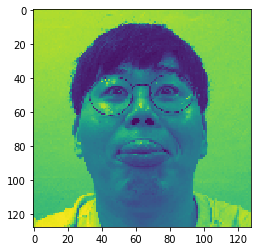

In [516]:
plt.imshow(pairs[0,15].reshape(128,128))
plt.show()

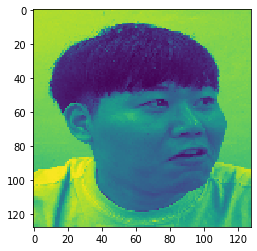

In [518]:
plt.imshow(pairs[1,18].reshape(128,128))
plt.show()

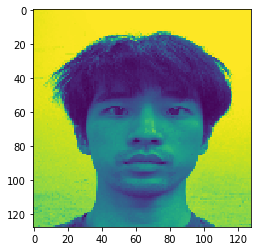

In [150]:
plt.imshow(pairs[1,32].reshape(128,128))
plt.show()

In [519]:
history_dict = model.history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [520]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

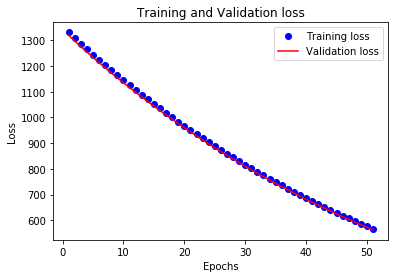

In [525]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

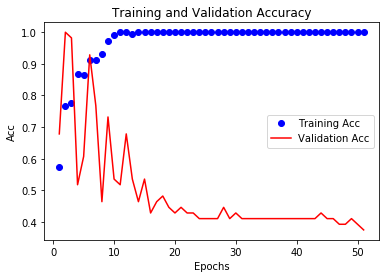

In [527]:
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'red', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

# Load Test Image

In [253]:
test,_,_ = load_imgs(test_path)

Loading Image: lim
Loading Image: misang
Loading Image: misang2


In [255]:
test.shape

(3, 3, 128, 128)

In [262]:
test[:,1].shape

(3, 128, 128)

In [288]:
test1 = test[0,0].reshape(1,128,128,1)
test2 = test[0,1].reshape(1,128,128,1)
test3 = test[0,2].reshape(1,128,128,1)
test4 = test[1,0].reshape(1,128,128,1)
test5 = test[1,1].reshape(1,128,128,1)
test6 = test[1,2].reshape(1,128,128,1)
test7 = test[2,0].reshape(1,128,128,1)
test8 = test[2,1].reshape(1,128,128,1)
test9 = test[2,2].reshape(1,128,128,1)

In [401]:
stand = np.concatenate([test3, test2, test1, test1, test1, test1,test1, test1, test1] ).reshape(9, 128, 128, 1)
misang = test.reshape(9, 128, 128, 1)

In [421]:
misang.shape

(9, 128, 128, 1)

# 9개의 test 데이터

In [502]:
pred_test = model.predict([stand, misang])

In [503]:
pred_test

array([[0.65111876],
       [0.64042175],
       [0.65111876],
       [0.28038436],
       [0.0021669 ],
       [0.07769322],
       [0.03735647],
       [0.03296211],
       [0.47840565]], dtype=float32)

In [504]:
prediction(pred_test, [1,1,1]+[0]*6)

Test Accuracy : 100.0%


In [481]:
def plot_image(i, img):
    if i < 9:
        plt.subplot(2,9,i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img[i, ... , 0])
        
    plt.subplot(2,9, i+1)    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img[i-9, ... , 0])

C:\Users\Cau_13\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


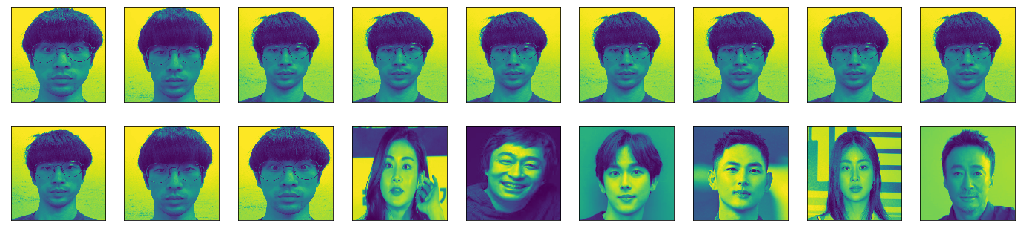

In [484]:
plt.figure(figsize=(18,4))
for i in range(9):
    plot_image(i, stand)
for i in range(9,18):
    plot_image(i, misang)

## 생각보다 잘 구분해 낸다.

## 참고 사이트)
https://sorenbouma.github.io/blog/oneshot/

https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d

## 참고 코드)
https://github.com/shubham0204/Face_Recognition_with_TF

https://hub.packtpub.com/face-recognition-using-siamese-networks-tutorial/

https://github.com/hlamba28/One-Shot-Learning-with-Siamese-Networks/blob/master/Siamese%20on%20Omniglot%20Dataset.ipynb